# **Projeto PCD: K-means 1D (naive) com Paralelização Progressiva**

## Profs. Álvaro e Denise (Turmas I e N)

O algoritmo K-Means realiza uma operação de agrupamento ("clusterização") para mineração de dados, ou seja, permite agrupar amostras de um dado conjunto em grupos homogêneos. O método particiona um conjunto de *n* observações (pontos) em *k* grupos, onde cada ponto será associado ao grupo cuja média seja a mais próxima. A distância Euclidiana é geralmente a métrica adotada para medir a proximidade.
A "clusterização" é um problema *NP-hard*, mas existem algoritmos heurísticos eficientes que podem rapidamente encontrar um ótimo local. Nesta implementação, a aplicação recebe como entrada as coordenadas (1D) de *k* centróides iniciais e um conjunto de dados. O K-Means realiza um processo iterativo, no qual os pontos são reagrupados de acordo com a menor distância Euclidiana entre eles e os centróides. Em seguida, o centróide de cada partição é recalculado tomando a média de todos os pontos da partição, e todo o procedimento é repetido até que nenhum centróide seja alterado e nenhum ponto seja atribuído a outro grupo. Ao final, o algoritmo retorna as coordenadas dos *k* centróides finais.


## Objetivo

Implementar o **k-means em 1 dimensão** (pontos `X[i]` e centróides `C[c]`), medir **SSE** e **desempenho**, e **paralelizar** o núcleo do algoritmo em três etapas independentes:

1. **OpenMP (CPU memória compartilhada)**
2. **CUDA (GPU)**
3. **MPI (memória distribuída)**

## Entradas e saídas

* **Entradas (CSV, 1 coluna, sem cabeçalho):**

  * `dados.csv` com **N** valores (pontos).
  * `centroides_iniciais.csv` com **K** valores.
* **Saídas:**

  * No terminal: **iterações**, **SSE (*Sum of Squared Errors*, ou Soma dos Erros Quadráticos, em português) final**, **tempo total** (ms).
  * Arquivos: `assign.csv` (N linhas, índice do cluster por ponto) e `centroids.csv` (K linhas com centróides finais).

## Algoritmo (base “naive”)

Itere até `max_iter` ou até variar pouco o SSE (`eps`):

1. **Assignment:** para cada ponto, escolher o centróide mais próximo (minimiza $(x_i - c)^2$); acumular **SSE**.
2. **Update:** para cada cluster, **média** dos pontos atribuídos. Se um cluster ficar vazio, **copie `X[0]`** (estratégia simples).

---

## Etapa 0 — Versão sequencial (baseline)

* Executar a versão **sequencial** (fornecida mais abaixo).
* Coletar: **SSE por iteração**, **tempo total**, **iterações**.
* Salvar esses números: serão a **linha de base** para speedup.

---

## Etapa 1 — OpenMP (CPU)

**Meta:** paralelizar as funções de *assignment* e *update* na CPU.

### O que paralelizar

* **Assignment:** laço `for (i=0; i<N; ++i)`.
* **Update:**

  * opção A (mais simples): usar **acumuladores por thread** (`sum_thread[c]`, `cnt_thread[c]`) e **reduzir** após a região paralela;
  * opção B: usar `#pragma omp critical` e verificar impactos no desempenho.

### Medições

* **Escalonamento em threads:** T ∈ {1, 2, 4, 8, 16, …}.
* **Speedup** = tempo_serial / tempo_OpenMP.
* **Afinar:** *schedule* (`static` vs `dynamic`) e *chunk size*.
* **Validação:** SSE não deve **aumentar** ao longo das iterações (pode ficar igual se convergiu).

### Dica de compilação

```bash
gcc -O2 -fopenmp -std=c99 kmeans_1d_omp.c -o kmeans_1d_omp -lm
```

---

## Etapa 2 — CUDA (GPU)

**Meta:** mover o **assignment** para a GPU; o **update** pode ser feito na GPU (com atomics) ou no host (copiando `assign`).

### Desenho mínimo

* **Kernel de assignment:** 1 *thread* por ponto `i`.

  * Cada thread varre **K** centróides, calcula `d = (X[i]-C[c])^2`, guarda o melhor e escreve `assign[i]`.
  * (Opcional) carregar `C` em **memória constante**.
* **SSE:** reduzir no host somando os erros por ponto (ou fazer redução em blocos).
* **Update:**

  * opção A (mais simples): copiar `assign` para CPU e calcular médias no host;
  * opção B: usar **atomics** em `sum[c]` e `cnt[c]` na GPU e depois dividir.

### Medições

* **Tamanho de bloco** (p.ex., 128, 256, 512) × **grid**;
* **Tempos**: H2D/D2H, *kernel*, total;
* **Throughput**: pontos/s; **speedup** vs. serial e vs. OpenMP.

### Dica de compilação

```bash
nvcc -O2 kmeans_1d_cuda.cu -o kmeans_1d_cuda
```

---

## Etapa 3 — MPI (distribuída)

**Meta:** distribuir os **N** pontos entre **P** processos; centróides são **globais** a cada iteração.

### Passos por iteração

1. **Broadcast** (ou inicialização compartilhada): todos os processos têm `C`.
2. **Assignment local:** cada processo calcula `assign_local` e `SSE_local` para seu bloco de pontos.
3. **Redução global:**

   * somar `SSE_local` → `SSE_global` com `MPI_Reduce`;
   * somar `sum_local[c]` e `cnt_local[c]` para todos os clusters com `MPI_Allreduce`;
   * cada processo atualiza `C` com os resultados globais.
4. Próxima iteração até convergir.

### Medições

* **Strong scaling:** P ∈ {1, 2, 4, 8, …}.
* **Tempo de comunicação:** destacar o custo de `Allreduce`.
* **Speedup** vs. serial e OpenMP.

### Dica de compilação/execução

```bash
mpicc -O2 -std=c99 kmeans_1d_mpi.c -o kmeans_1d_mpi -lm
mpirun -np 4 ./kmeans_1d_mpi dados.csv centroides_iniciais.csv [args...]
```

---

## Conjuntos de teste sugeridos (1D)

* **Pequeno:** N=10^4, K=4
* **Médio:** N=10^5, K=8
* **Grande:** N=10^6, K=16 (se houver memória)
  Gere dados com mistura de faixas (ex.: perto de 0, 10, 20, 30) para facilitar a verificação visual.

---

## O que entregar

1. **Código no github**: `serial/`, `openmp/`, `cuda/`, `mpi/` (cada pasta com `README.md` de como compilar/rodar).
2. **Relatório curto (4–6 págs po etapa)**:

   * Ambiente (CPU/GPU/RAM/rede; versões de compilador).
   * Gráficos: **tempo**, **speedup**, **pontos/s** por etapa.
   * Para MPI: curva de **speedup** e comentário sobre custo de `Allreduce`.
   * Para CUDA: impacto de **block size** e custo de **transferência**.
   * Para OpenMP: efeito de **nº de threads** e de *schedule*.
   * Seções de **validação** (SSE por iteração, convergência, igualdade de resultados entre versões dentro de tolerância).
   * Análise de resultados e conclusões
   * Referências bibliográficas: apresente uma pequena revisão bibliográfica e compare seus resultados com outros encontrados na literatura.

---

## Critérios de avaliação

* **Desempenho e análise** (speedup, tempos de execução, eficiência e gargalos por arquitetura): **30%**
* **Corretude e reprodutibilidade** (SSE consistente, convergência, demonstração da corretude da execução): **30%**
* **Relatório** (clareza, gráficos, referências bibliográficas, análises e conclusões): **20%**
* **Qualidade do código e organização**: **10%**
* **Extra** (implementação e/ou análises não sugeridas no enunciado e que melhorem a qualidade científica do trabalho): **10%**


---

## Dicas rápidas

* Padronize **parâmetros** (N, K, `max_iter`, `eps`) entre as versões para comparar.
* Fixe uma **semente** ao gerar dados (quando aplicável) para repetibilidade.



##Exemplo: código sequencial e arquivos de entrada e saída

In [ ]:
import numpy as np

# Generate 100 random numbers
random_data = np.random.rand(10**6, 1)


# Write the data to a CSV file
with open('dados.csv', 'w') as f:
    for item in random_data:
        f.write(f"{item[0]}\n")

print(f"Generated dados_aleatorios.csv with {5*10**6} random numbers.")

Generated dados_aleatorios.csv with 5000000 random numbers.


In [ ]:
# Generate 100 random numbers
random_data = np.random.rand(10, 1)


# Write the data to a CSV file
with open('centroides_iniciais.csv', 'w') as f:
    for item in random_data:
        f.write(f"{item[0]}\n")

print("Generated centroides_iniciais.csv with 10 random numbers.")

Generated centroides_iniciais.csv with 10 random numbers.


In [ ]:
%%writefile kmeans_1d_naive.c

/* kmeans_1d_naive.c
   K-means 1D (C99), implementação "naive":
   - Lê X (N linhas, 1 coluna) e C_init (K linhas, 1 coluna) de CSVs sem cabeçalho.
   - Itera assignment + update até max_iter ou variação relativa do SSE < eps.
   - Salva (opcional) assign (N linhas) e centróides finais (K linhas).

   Compilar: gcc -O2 -std=c99 kmeans_1d_naive.c -o kmeans_1d_naive -lm
   Uso:      ./kmeans_1d_naive dados.csv centroides_iniciais.csv [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]
*/

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>

/* ---------- util CSV 1D: cada linha tem 1 número ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }

    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }

    char line[8192];
    int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;

        /* aceita vírgula/ponto-e-vírgula/espaco/tab, pega o primeiro token numérico */
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); fclose(f); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f);
    *n_out = R;
    return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

// ---------- k-means 1D ----------
 /* assignment: para cada X[i], encontra c com menor (X[i]-C[c])^2 */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;
    for(int i=0;i<N;i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0;c<K;c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        sse += bestd;
    }
    return sse;
}

/* update: média dos pontos de cada cluster (1D)
   se cluster vazio, copia X[0] (estratégia naive) */
static void update_step_1d(const double *X, double *C, const int *assign, int N, int K){
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    if(!sum || !cnt){ fprintf(stderr,"Sem memoria no update\n"); exit(1); }

    for(int i=0;i<N;i++){
        int a = assign[i];
        cnt[a] += 1;
        sum[a] += X[i];
    }
    for(int c=0;c<K;c++){
        if(cnt[c] > 0) C[c] = sum[c] / (double)cnt[c];
        else           C[c] = X[0]; /* simples: cluster vazio recebe o primeiro ponto */
    }
    free(sum); free(cnt);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out)
{
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);
        /* parada por variação relativa do SSE */
        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps){ it++; break; }
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */
int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]\n", argv[0]);
        printf("Obs: arquivos CSV com 1 coluna (1 valor por linha), sem cabeçalho.\n");
        return 1;
    }// k-means 1D
    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int max_iter = (argc>3)? atoi(argv[3]) : 50;
    double eps   = (argc>4)? atof(argv[4]) : 1e-4;
    const char *outAssign   = (argc>5)? argv[5] : NULL;
    const char *outCentroid = (argc>6)? argv[6] : NULL;

    if(max_iter <= 0 || eps <= 0.0){
        fprintf(stderr,"Parâmetros inválidos: max_iter>0 e eps>0\n");
        return 1;
    }

    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); return 1; }

    clock_t t0 = clock();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse);
    clock_t t1 = clock();
    double ms = 1000.0 * (double)(t1 - t0) / (double)CLOCKS_PER_SEC;

    printf("K-means 1D (naive)\n");
    printf("N=%d K=%d max_iter=%d eps=%g\n", N, K, max_iter, eps);
    printf("Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);

    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);

    free(assign); free(X); free(C);
    return 0;
}


Overwriting kmeans_1d_naive.c


### Saída para teste de valores

In [ ]:
%%shell

gcc -O2 -std=c99 kmeans_1d_naive.c -o kmeans_1d_naive -lm

# Separar pastas de resultados sequenciais e paralelos
mkdir -p sequential

./kmeans_1d_naive /content/dados.csv /content/centroides_iniciais.csv 50 0.000001 sequential/assign.csv sequential/centroids.csv

echo "--- Conteúdo do arquivo de centróides ---"
cat sequencial/centroids.csv

K-means 1D (naive)
N=100000 K=4 max_iter=50 eps=1e-06
Iterações: 43 | SSE final: 521.109831 | Tempo: 19.3 ms
--- Conteúdo do arquivo de centróides ---
0.875353
0.124881
0.375753
0.625326


In [ ]:
%%shell

ls /content/

assign.csv		 centroids.csv	kmeans_1d_naive    sample_data
centroides_iniciais.csv  dados.csv	kmeans_1d_naive.c


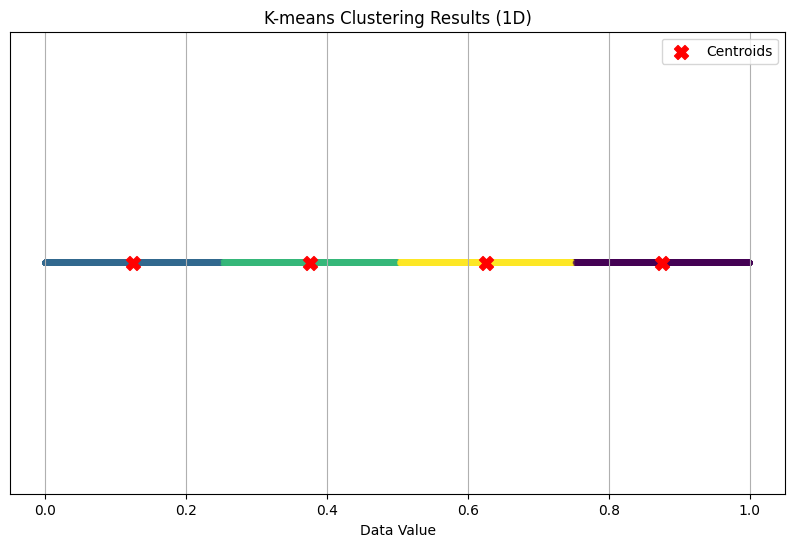

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the assignment and centroid files
assign_df = pd.read_csv('sequential/assign.csv', header=None, names=['cluster'])
centroids_df = pd.read_csv('sequential/centroids.csv', header=None, names=['centroid'])

# Assuming the original data is in 'dados.csv'
# We need to read the original data to plot it
try:
    data_df = pd.read_csv('dados.csv', header=None, names=['value'])
except FileNotFoundError:
    print("Error: dados.csv not found. Please make sure the original data file exists.")
    # Exit or handle the error appropriately
    exit()


# Add the cluster assignments to the data DataFrame
data_df['cluster'] = assign_df['cluster']

# Plot the data points, colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(data_df['value'], [0] * len(data_df), c=data_df['cluster'], cmap='viridis', s=10, alpha=0.6)

# Plot the centroids
plt.scatter(centroids_df['centroid'], [0] * len(centroids_df), c='red', s=100, marker='X', label='Centroids')

plt.title('K-means Clustering Results (1D)')
plt.xlabel('Data Value')
plt.yticks([]) # Hide the y-axis ticks for 1D visualization
plt.legend()
plt.grid(True)
plt.show()

#### Fim das saídas para teste

## Implementação K-Means em OpenMP

In [ ]:
%%writefile kmeans_omp.c

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>
#include <omp.h>

/* ---------- util CSV 1D: cada linha tem 1 número ---------- */
static int count_rows(const char *path){
    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); exit(1); }
    int rows=0; char line[8192];
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(!only_ws) rows++;
    }
    fclose(f);
    return rows;
}

static double *read_csv_1col(const char *path, int *n_out){
    int R = count_rows(path);
    if(R<=0){ fprintf(stderr,"Arquivo vazio: %s\n", path); exit(1); }
    double *A = (double*)malloc((size_t)R * sizeof(double));
    if(!A){ fprintf(stderr,"Sem memoria para %d linhas\n", R); exit(1); }

    FILE *f = fopen(path, "r");
    if(!f){ fprintf(stderr,"Erro ao abrir %s\n", path); free(A); exit(1); }

    char line[8192];
    int r=0;
    while(fgets(line,sizeof(line),f)){
        int only_ws=1;
        for(char *p=line; *p; p++){
            if(*p!=' ' && *p!='\t' && *p!='\n' && *p!='\r'){ only_ws=0; break; }
        }
        if(only_ws) continue;
        const char *delim = ",; \t";
        char *tok = strtok(line, delim);
        if(!tok){ fprintf(stderr,"Linha %d sem valor em %s\n", r+1, path); free(A); fclose(f); exit(1); }
        A[r] = atof(tok);
        r++;
        if(r>R) break;
    }
    fclose(f);
    *n_out = R;
    return A;
}

static void write_assign_csv(const char *path, const int *assign, int N){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int i=0;i<N;i++) fprintf(f, "%d\n", assign[i]);
    fclose(f);
}

static void write_centroids_csv(const char *path, const double *C, int K){
    if(!path) return;
    FILE *f = fopen(path, "w");
    if(!f){ fprintf(stderr,"Erro ao abrir %s para escrita\n", path); return; }
    for(int c=0;c<K;c++) fprintf(f, "%.6f\n", C[c]);
    fclose(f);
}

/* ---------- k-means 1D ---------- */
static double assignment_step_1d(const double *X, const double *C, int *assign, int N, int K){
    double sse = 0.0;

    // schedule(runtime) permite controlar 'static'/'dynamic' e chunk via 'OMP_SCHEDULE'
    #pragma omp parallel for reduction(+:sse) schedule(runtime)
    for(int i=0;i<N;i++){
        int best = -1;
        double bestd = 1e300;
        for(int c=0;c<K;c++){
            double diff = X[i] - C[c];
            double d = diff*diff;
            if(d < bestd){ bestd = d; best = c; }
        }
        assign[i] = best;
        sse += bestd;
    }
    return sse;
}

static void update_step_1d(const double *X, double *C, const int *assign, int N, int K) {
    double *sum = (double*)calloc((size_t)K, sizeof(double));
    int *cnt = (int*)calloc((size_t)K, sizeof(int));
    int n_threads = omp_get_max_threads();
    double *sum_private = (double*)calloc((size_t)n_threads * K, sizeof(double));
    int *cnt_private = (int*)calloc((size_t)n_threads * K, sizeof(int));

    if (!sum || !cnt || !sum_private || !cnt_private) {
        fprintf(stderr, "Sem memoria no update\n");
        free(sum);
        free(cnt);
        free(sum_private);
        free(cnt_private);
        exit(1);
    }

    #pragma omp parallel
    {
      int id = omp_get_thread_num();
      double *my_sum = &sum_private[id * K];
      int *my_cnt = &cnt_private[id * K];

      #pragma omp for schedule(runtime) // Controlado por OMP_SCHEDULE
        for (int i = 0; i < N; i++) {
            int a = assign[i];
            if (a >= 0 && a < K) {
                my_cnt[a] += 1;
                my_sum[a] += X[i];
            }
        }

      #pragma omp for schedule(runtime) // Controlado por OMP_SCHEDULE
        for (int c = 0; c < K; c++) {
          for (int t = 0; t < n_threads; t++) {
            sum[c] += sum_private[t * K + c];
            cnt[c] += cnt_private[t * K + c];
          }
        }
    }

    for (int c = 0; c < K; c++) {
      if (cnt[c] > 0)
        C[c] = sum[c] / (double)cnt[c];
      else
        C[c] = X[0];
    }
    free(sum);
    free(cnt);
    free(sum_private);
    free(cnt_private);
}

static void kmeans_1d(const double *X, double *C, int *assign,
                      int N, int K, int max_iter, double eps,
                      int *iters_out, double *sse_out)
{
    double prev_sse = 1e300;
    double sse = 0.0;
    int it;
    for(it=0; it<max_iter; it++){
        sse = assignment_step_1d(X, C, assign, N, K);

        // --- MODIFICAÇÃO: Imprime SSE a cada iteração para validação ---
        printf("SSE_ITER: %d %.6f\n", it, sse);

        double rel = fabs(sse - prev_sse) / (prev_sse > 0.0 ? prev_sse : 1.0);
        if(rel < eps){ it++; break; }
        update_step_1d(X, C, assign, N, K);
        prev_sse = sse;
    }
    *iters_out = it;
    *sse_out = sse;
}

/* ---------- main ---------- */
int main(int argc, char **argv){
    if(argc < 3){
        printf("Uso: %s dados.csv centroides_iniciais.csv [max_iter=50] [eps=1e-4] [assign.csv] [centroids.csv]\n", argv[0]);
        return 1;
    } // --- CORREÇÃO: Removido "k-means 1D" daqui ---

    const char *pathX = argv[1];
    const char *pathC = argv[2];
    int max_iter = (argc>3)? atoi(argv[3]) : 50;
    double eps   = (argc>4)? atof(argv[4]) : 1e-4;
    const char *outAssign   = (argc>5)? argv[5] : NULL;
    const char *outCentroid = (argc>6)? argv[6] : NULL;

    if(max_iter <= 0 || eps <= 0.0){
        fprintf(stderr,"Parâmetros inválidos: max_iter>0 e eps>0\n");
        return 1;
    }

    int N=0, K=0;
    double *X = read_csv_1col(pathX, &N);
    double *C = read_csv_1col(pathC, &K);
    int *assign = (int*)malloc((size_t)N * sizeof(int));
    if(!assign){ fprintf(stderr,"Sem memoria para assign\n"); free(X); free(C); return 1; }

    // para medir tempo
    double t0 = omp_get_wtime();
    int iters = 0; double sse = 0.0;
    kmeans_1d(X, C, assign, N, K, max_iter, eps, &iters, &sse);
    double t1 = omp_get_wtime();
    double ms = 1000.0 * (t1 - t0);

    // Imprimir em stderr para não poluir o stdout (que o Python lerá)
    fprintf(stderr, "K-means 1D (OpenMP)\n");
    fprintf(stderr, "N=%d K=%d max_iter=%d eps=%g\n", N, K, max_iter, eps);
    fprintf(stderr, "Threads: %d\n", omp_get_max_threads());
    fprintf(stderr, "Iterações: %d | SSE final: %.6f | Tempo: %.1f ms\n", iters, sse, ms);

    printf("FINAL_DATA: Time=%.1f Threads=%d SSE=%.6f Iters=%d N=%d K=%d\n",
           ms, omp_get_max_threads(), sse, iters, N, K);

    write_assign_csv(outAssign, assign, N);
    write_centroids_csv(outCentroid, C, K);

    free(assign); free(X); free(C);
    return 0;
}

Overwriting kmeans_omp.c


## Orquestrando as saídas dos códigos sequenciais, para automatizar testes

### Imports para manipulação de arquivos, códigos e resultados, e calculos

In [ ]:
import os
import subprocess
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Preparando ambientes e entradas

In [ ]:
# Arquivos C
k_naive_file = "kmeans_1d_naive.c"
k_naive_exec = "kmeans_1d_naive"
k_omp_file = "kmeans_omp.c"
k_omp_exec = "kmeans_omp"

# Arquivos de DADOS
data_file = "dados.csv"
centros_init_file = "centroides_iniciais.csv"

# Parâmetros K-means
iterac = 50
e_convergence = 1e-6

# Parâmetros de Medição
n_th_tests = [1, 2, 4, 8, 16]
schedlls = ["static", "dynamic"]
chk_sizes = [1, 1024, 4096]

# --- Pastas de Saída ---
seq_output_dir = "sequential"
output_dir = "parallel"
plot_dir = "parallel_plots"


### Funções de manejamento de códigos e dados saída

#### Compilações

In [ ]:
def compile_C_naive():
    print(f"Compilando {k_naive_file} -> {k_naive_exec}...")
    try:
        subprocess.run(
            ["gcc", "-O2", "-std=c99", k_naive_file, "-o", k_naive_exec, "-lm"],
            check=True, capture_output=True, text=True
        )
        print("Compilação (naive) bem-sucedida.")
    except subprocess.CalledProcessError as e:
        print("ERRO NA COMPILAÇÃO (naive):")
        print(e.stderr)
        exit(1)

def compile_C_omp():
    print(f"Compilando {k_omp_file} -> {k_omp_exec}...")
    try:
        subprocess.run(
            ["gcc", "-O2", "-std=c99", "-fopenmp", k_omp_file, "-o", k_omp_exec, "-lm"],
            check=True, capture_output=True, text=True
        )
        print("Compilação (OMP) bem-sucedida.")
    except subprocess.CalledProcessError as e:
        print("ERRO NA COMPILAÇÃO (OMP):")
        print(e.stderr)
        exit(1)

#### Manejamento de saídas dos códigos C para comparação

In [ ]:
def parse_output_naive(stdout):
    time_ms = 0.0
    sse_final = 0.0

    result_regex = r"Iterações: \d+ \| SSE final: ([\d\.]+) \| Tempo: ([\d\.]+) ms"

    match = re.search(result_regex, stdout)
    if match:
        sse_final = float(match.group(1))
        time_ms = float(match.group(2))
    else:
        print("ERRO: Não foi possível parsear a saída do código sequencial.")
        print("Saída recebida:", stdout)

    return time_ms, sse_final


# pegar as saídas do kmeans_omp
def parse_output(stdout):
    sse_per_iter = []
    final_data = {}

    sse_regex = r"SSE_ITER: (\d+) ([\d\.]+)"
    for line in stdout.splitlines():
        match = re.match(sse_regex, line)
        if match:
            sse_per_iter.append({
                "iter": int(match.group(1)),
                "sse": float(match.group(2))
            })

    final_regex = (
        r"FINAL_DATA: Time=([\d\.]+) Threads=(\d+) SSE=([\d\.]+) "
        r"Iters=(\d+) N=(\d+) K=(\d+)"
    )
    match = re.search(final_regex, stdout)
    if match:
        final_data = {
            "Time_ms": float(match.group(1)),
            "Threads": int(match.group(2)),
            "SSE_final": float(match.group(3)),
            "Iterations": int(match.group(4)),
            "N": int(match.group(5)), # Captura N
            "K": int(match.group(6)), # Captura K
        }
    return final_data, sse_per_iter

#### Rodar preparo de baseline com base no código sequencial

In [ ]:
def run_sequential_baseline():
    print("\n--- Executando Baseline Sequencial (kmeans_1d_naive) ---")

    os.makedirs(seq_output_dir, exist_ok=True)
    seq_assign_file = os.path.join(seq_output_dir, "assign.csv")
    seq_centroids_file = os.path.join(seq_output_dir, "centroids.csv")

    cmd = [
        f"./{k_naive_exec}",
        data_file,
        centros_init_file,
        str(iterac),
        str(e_convergence),
        seq_assign_file,
        seq_centroids_file
    ]

    try:
        result = subprocess.run(
            cmd, capture_output=True, text=True, check=True
        )

        time_ms, sse_final = parse_output_naive(result.stdout)

        if time_ms == 0.0:
            print("Não foi possível obter o baseline. Verifique o 'parse_output_naive'.")
            exit(1)

        print(f"Baseline (Sequencial): Tempo={time_ms:.1f} ms, SSE Final={sse_final:.6f}")
        print(f"Resultados sequenciais (assign/centroids) salvos em: {seq_output_dir}")

        return time_ms, sse_final

    except subprocess.CalledProcessError as e:
        print("ERRO ao executar o baseline sequencial:")
        print(f"STDOUT: {e.stdout}")
        print(f"STDERR: {e.stderr}")
        exit(1)


#### Funções de plot

In [ ]:
def create_performance_plots(df, sse_data_t1, N, K):
    """Gera os plots de PERFORMANCE (SSE, Speedup, Tuning)."""
    print("\n--- Gerando Plots de Performance ---")
    os.makedirs(plot_dir, exist_ok=True)

    # 1. Validação do SSE (Usa os dados de T=2 do OMP)
    if sse_data_t1:
        plt.figure(figsize=(10, 6))
        sse_df = pd.DataFrame(sse_data_t1)
        plt.plot(sse_df["iter"], sse_df["sse"], marker='o', linestyle='-')

        # --- (MODIFICAÇÃO) ---
        plt.title("Validação: Convergência do SSE (Execução OMP T=2)")

        plt.xlabel("Iteração")
        plt.ylabel("SSE (Soma dos Erros Quadráticos)")
        plt.grid(True)
        plt.savefig(os.path.join(plot_dir, "1_validacao_sse.png"))
        print(f"Salvo: {plot_dir}/1_validacao_sse.png")
        plt.close()

    # 2. Speedup vs. Threads (Usa o baseline real)
    plt.figure(figsize=(12, 8))
    for (schedule, chunk), group in df.groupby(['Schedule', 'Chunk']):
        label = f"{schedule}, chunk={chunk}"
        plt.plot(group['Threads'], group['Speedup'], marker='o', label=label)

    plt.plot(n_th_tests, n_th_tests, linestyle='--', color='k', label='Speedup Ideal')
    plt.title(f"Escalonamento e Speedup do K-means (N={N}, K={K})")
    plt.xlabel("Número de Threads")
    plt.ylabel("Speedup (Tempo Serial / Tempo OMP)")
    plt.xticks(n_th_tests)
    plt.legend(title="Schedule, Chunk", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "2_speedup_vs_threads.png"))
    print(f"Salvo: {plot_dir}/2_speedup_vs_threads.png")
    plt.close()

    # 3. Afinar Schedule e Chunk
    max_threads = df['Threads'].max()
    df_max_threads = df[df['Threads'] == max_threads].copy()
    if not df_max_threads.empty:
        df_max_threads['Config'] = df_max_threads.apply(
            lambda row: f"{row['Schedule']}, {row['Chunk']}", axis=1
        )
        df_max_threads = df_max_threads.sort_values(by="Time_ms")
        plt.figure(figsize=(12, 7))
        bars = plt.bar(df_max_threads['Config'], df_max_threads['Time_ms'])
        plt.bar_label(bars, fmt='%.1f ms')
        plt.title(f"Afinando: Tempo de Execução com {max_threads} Threads")
        plt.xlabel("Configuração (Schedule, Chunk Size)")
        plt.ylabel("Tempo de Execução (ms)")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, "3_afinar_schedule_chunk.png"))
        print(f"Salvo: {plot_dir}/3_afinar_schedule_chunk.png")
        plt.close()

def plot_cluster_results(N, K):
    """
    (MODIFICADO) Lê os resultados da execução PARALELA (T=8) e plota.
    """
    print("\n--- Gerando Plot de Visualização dos Clusters (Paralelo T=8) ---")

    # Ler da pasta 'parallel/' os resultados de T=8
    assign_file = os.path.join(output_dir, "assign_T8.csv")
    centroids_file = os.path.join(output_dir, "centroids_T8.csv")

    try:
        assign_df = pd.read_csv(assign_file, header=None, names=['cluster'])
        centroids_df = pd.read_csv(centroids_file, header=None, names=['centroid'])
        # Os dados (pontos) ainda são os mesmos
        data_df = pd.read_csv(data_file, header=None, names=['value'])
    except FileNotFoundError as e:
        print(f"Erro ao ler arquivos de resultado de T=8 de '{output_dir}': {e}")
        print(f"Verifique se '{assign_file}' e '{centroids_file}' existem.")
        print("Pulando plot de visualização.")
        return

    data_df['cluster'] = assign_df['cluster']

    plt.figure(figsize=(12, 6))
    plt.scatter(data_df['value'], [0] * len(data_df), c=data_df['cluster'], cmap='viridis', s=10, alpha=0.6, label="Pontos de Dados")
    plt.scatter(centroids_df['centroid'], [0] * len(centroids_df), c='red', s=150, marker='X', label='Centroides Finais (T=8)', edgecolors='black')


    # Título reflete a execução T=8
    plt.title(f'Visualização K-means (1D) - Resultado Paralelo (T=8) (N={N}, K={K})')
    plt.xlabel('Valor')
    plt.yticks([])
    plt.legend()
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, "4_visualizacao_clusters_T8.png"))
    print(f"Salvo: {plot_dir}/4_visualizacao_clusters_T8.png")
    plt.show()
    plt.close()




def create_centroid_comparison_plot(thread_count, N, K):

    seq_centroids_file = os.path.join(seq_output_dir, "centroids.csv")
    par_centroids_file = os.path.join(output_dir, f"centroids_T{thread_count}.csv")

    try:
        seq_df = pd.read_csv(seq_centroids_file, header=None, names=['Sequencial'])
        par_df = pd.read_csv(par_centroids_file, header=None, names=[f'Paralelo (T={thread_count})'])
    except FileNotFoundError as e:
        print(f"Erro ao ler arquivos de centroides para comparação (T={thread_count}): {e}")
        print(f"Verifique se '{seq_centroids_file}' e '{par_centroids_file}' existem.")
        print(f"Pulando plot de comparação de centroides para T={thread_count}.")
        return


#### Códigos finais - função de experimentos e Main

Compilando kmeans_1d_naive.c -> kmeans_1d_naive...
Compilação (naive) bem-sucedida.
Compilando kmeans_omp.c -> kmeans_omp...
Compilação (OMP) bem-sucedida.

--- Executando Baseline Sequencial (kmeans_1d_naive) ---
Baseline (Sequencial): Tempo=4546.0 ms, SSE Final=4191.293620
Resultados sequenciais (assign/centroids) salvos em: sequential

   Iniciando Experimentos (OpenMP) 
Valores detectados (OMP): N=5000000, K=10
Dados de convergência (SSE por it) capturados de T=2.
Resultados T=2 (assign/centroids) salvos em: parallel
Resultados T=4 (assign/centroids) salvos em: parallel
Resultados T=8 (assign/centroids) salvos em: parallel

--- Resultados Finais (DataFrame) ---
Baseline (Sequencial) Time: 4546.0 ms
Baseline (Sequencial) SSE: 4191.293620
    Time_ms  Threads   SSE_final  Iterations        N   K Schedule  Chunk   Speedup
0    3431.7        1  4191.29362          50  5000000  10   static      1  1.324708
1    4649.3        1  4191.29362          50  5000000  10   static   1024  0.9777

/tmp/ipython-input-1304763830.py:95: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-1304763830.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(plot_dir, "4_visualizacao_clusters_T8.png"))


Salvo: parallel_plots/4_visualizacao_clusters_T8.png


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


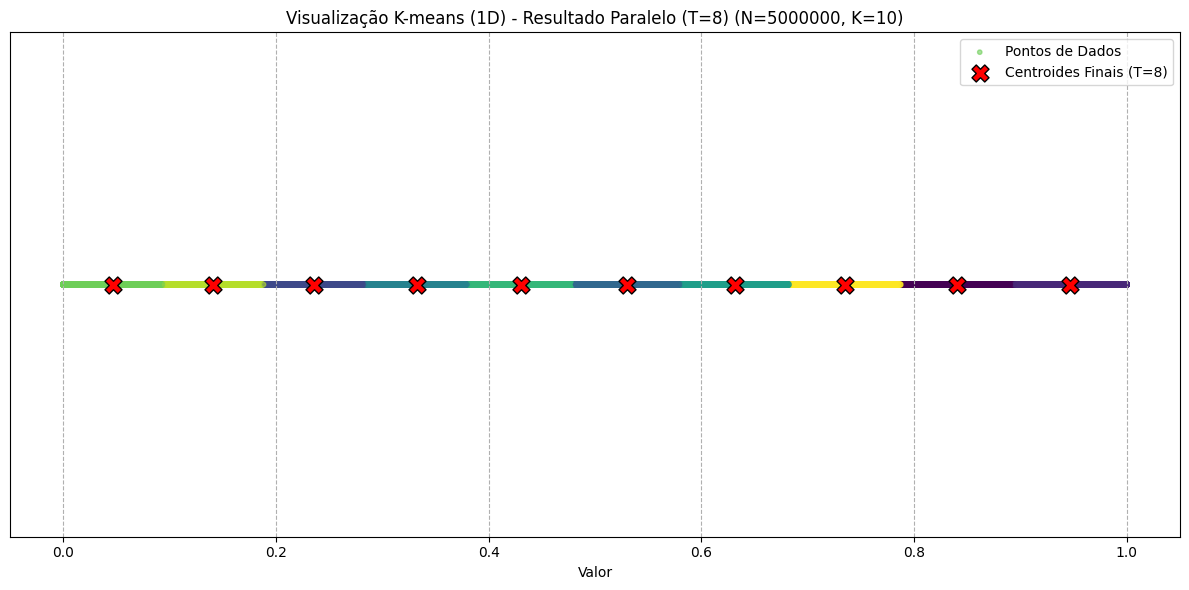


--- Gerando Tabelas de Comparação de Centroides ---

--- Experimento Concluído --- 
Plots salvos em: 'parallel_plots'


In [ ]:
# Executa o kmean_omp, coleta os resultados, e retorna N e K detectados
def run_experiments(serial_time_baseline):
    all_results = []
    sse_data_list_t1 = None # Nota: O nome da variável é mantido, mas ela conterá os dados de T=2
    N = 0
    K = 0

    print("\n   Iniciando Experimentos (OpenMP) ")
    os.makedirs(output_dir, exist_ok=True)

    for threads in n_th_tests:
        for schedule in schedlls:
            for chunk in chk_sizes:
                env = os.environ.copy()
                env["OMP_NUM_THREADS"] = str(threads)
                env["OMP_SCHEDULE"] = f"{schedule},{chunk}"

                config_label = f"T={threads}, Sched={schedule}, Chunk={chunk}"
                # print(f"Executando: {config_label}...")

                cmd = [
                    f"./{k_omp_exec}",
                    data_file,
                    centros_init_file,
                    str(iterac), str(e_convergence)
                ]

                # Salvar T= {2, 4, 8} (para tabelas e scatter plot)
                # Apenas na primeira config (static, chunk=1) para evitar muitos arquivos de saída
                threads_to_save = [2, 4, 8]
                is_first_config = (schedule == "static" and chunk == chk_sizes[0])

                if threads in threads_to_save and is_first_config:
                    assign_file_t = os.path.join(output_dir, f"assign_T{threads}.csv")
                    centroids_file_t = os.path.join(output_dir, f"centroids_T{threads}.csv")
                    cmd.extend([assign_file_t, centroids_file_t])

                try:
                    result = subprocess.run(
                        cmd, capture_output=True, text=True, env=env, check=True
                    )
                    final_data, sse_data = parse_output(result.stdout)

                    if not final_data:
                        print(f"Erro ao parsear saída para {config_label}")
                        continue

                    run_info = final_data.copy()
                    run_info["Schedule"] = schedule
                    run_info["Chunk"] = chunk
                    all_results.append(run_info)

                    if N == 0:
                        N = final_data.get("N", 0)
                        K = final_data.get("K", 0)
                        print(f"Valores detectados (OMP): N={N}, K={K}")

                    if threads == 2 and is_first_config and sse_data_list_t1 is None:
                        sse_data_list_t1 = sse_data
                        print(f"Dados de convergência (SSE por it) capturados de T=2.")
                        print(f"Resultados T=2 (assign/centroids) salvos em: {output_dir}")

                    #  para T=4 e T=8
                    elif threads in [4, 8] and is_first_config:
                         print(f"Resultados T={threads} (assign/centroids) salvos em: {output_dir}")


                except subprocess.CalledProcessError as e:
                    print(f"ERRO ao executar {config_label}:")
                    print(f"STDOUT: {e.stdout}")
                    print(f"STDERR: {e.stderr}")

    if N == 0 or K == 0:
        print("Erro: Não foi possível obter N/K das execuções OMP. Abortando.")
        exit(1)

    if sse_data_list_t1 is None:
         print("Aviso: Não foi possível capturar os dados de SSE por iteração (T=2).")

    df = pd.DataFrame(all_results)

    df["Speedup"] = serial_time_baseline / df["Time_ms"]

    return df, sse_data_list_t1, N, K

# ... (O resto das suas funções, como create_centroid_comparison_plot,
#      create_performance_plots, etc., permanecem aqui) ...

if __name__ == "__main__":
    # 1. Compilar os dois códigos
    compile_C_naive()
    compile_C_omp()

    # 2. Rodar o baseline sequencial
    serial_time_ms, serial_sse_final = run_sequential_baseline()

    # 3. Roda os experimentos OMP, passando o tempo_serial real
    results_df, sse_data_list_t1, N, K = run_experiments(serial_time_ms)

    print("\n--- Resultados Finais (DataFrame) ---")
    print(f"Baseline (Sequencial) Time: {serial_time_ms:.1f} ms")
    print(f"Baseline (Sequencial) SSE: {serial_sse_final:.6f}")
    print(results_df.to_string())

    # 4. Gerar plots de performance
    create_performance_plots(results_df, sse_data_list_t1, N, K)

    # 5. Gerar plot de visualização (MODIFICADO para usar T=8)
    plot_cluster_results(N, K)

    print("\n--- Gerando Tabelas de Comparação de Centroides ---")
    for t in [2, 4, 8]:
        create_centroid_comparison_plot(t, N, K)

    print(f"\n--- Experimento Concluído --- \nPlots salvos em: '{plot_dir}'")